## intial graph

Max Achievable Throughput: 267.514 KB/frame
Loaded trained policy network for inference!

=== Running simulation 1/100 ===
[Sim 1] => 
Time taken by ADSS: 0.0640 seconds
------------------------------------------------------------

=== Running simulation 2/100 ===


/tmp/ipykernel_372140/2844260182.py:1140: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  adss_agent.policy_net.load_state_dict(torch.load("ppo_policy_net.pth"))


[Sim 2] => 
Time taken by ADSS: 0.0674 seconds
------------------------------------------------------------

=== Running simulation 3/100 ===
[Sim 3] => 
Time taken by ADSS: 0.0679 seconds
------------------------------------------------------------

=== Running simulation 4/100 ===
[Sim 4] => 
Time taken by ADSS: 0.0684 seconds
------------------------------------------------------------

=== Running simulation 5/100 ===
[Sim 5] => 
Time taken by ADSS: 0.0786 seconds
------------------------------------------------------------

=== Running simulation 6/100 ===
[Sim 6] => 
Time taken by ADSS: 0.0764 seconds
------------------------------------------------------------

=== Running simulation 7/100 ===
[Sim 7] => 
Time taken by ADSS: 0.0709 seconds
------------------------------------------------------------

=== Running simulation 8/100 ===
[Sim 8] => 
Time taken by ADSS: 0.0750 seconds
------------------------------------------------------------

=== Running simulation 9/100 ===
[Sim 9

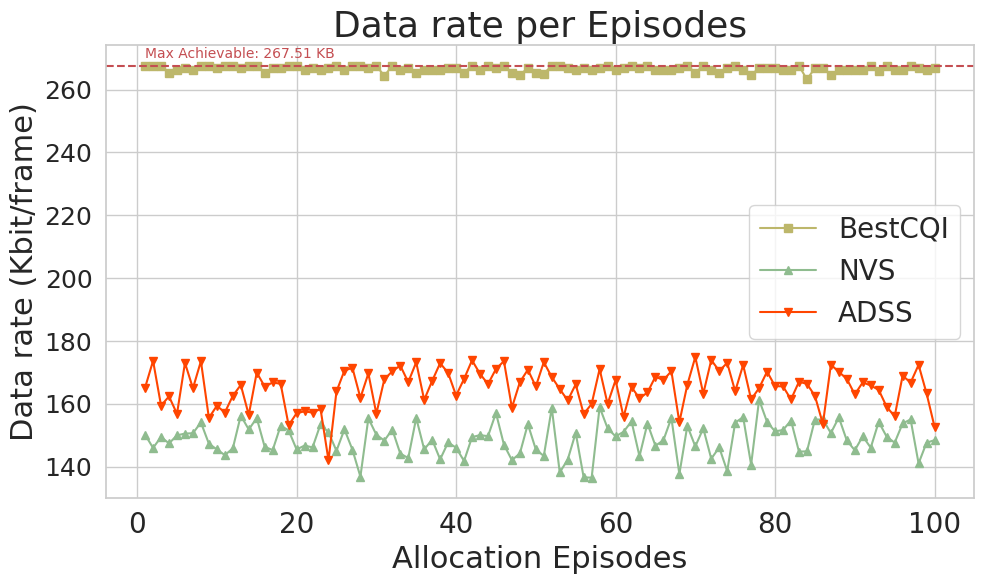

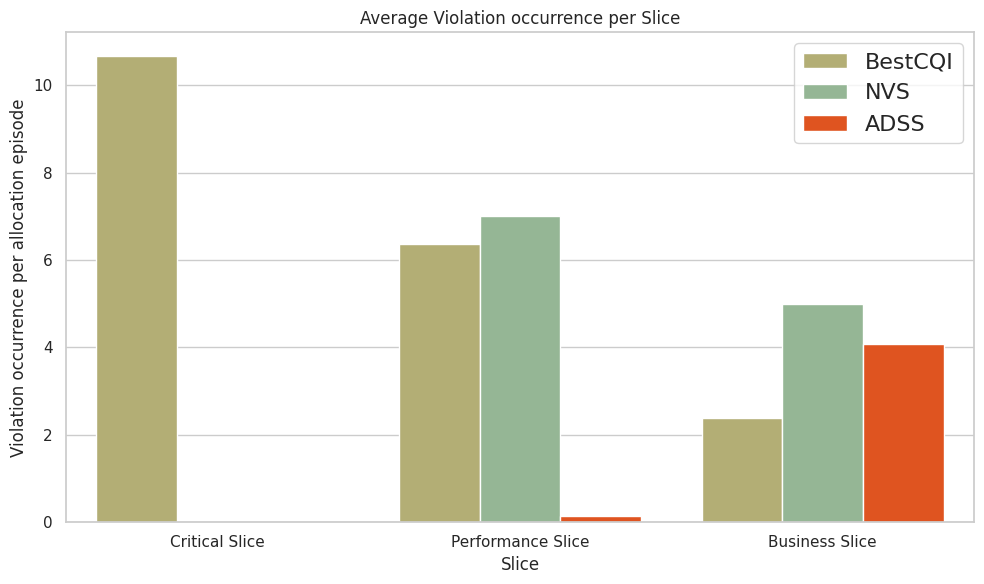

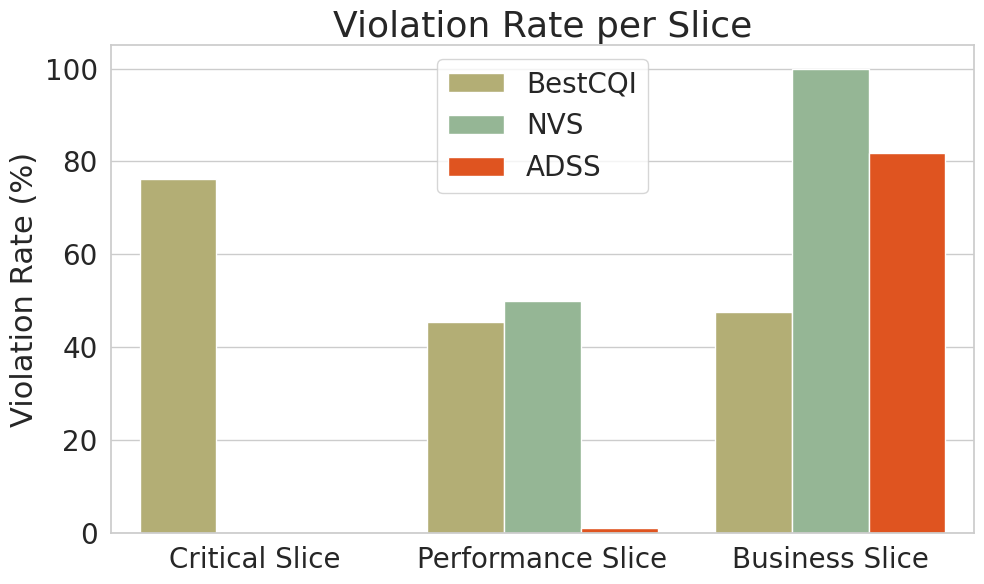

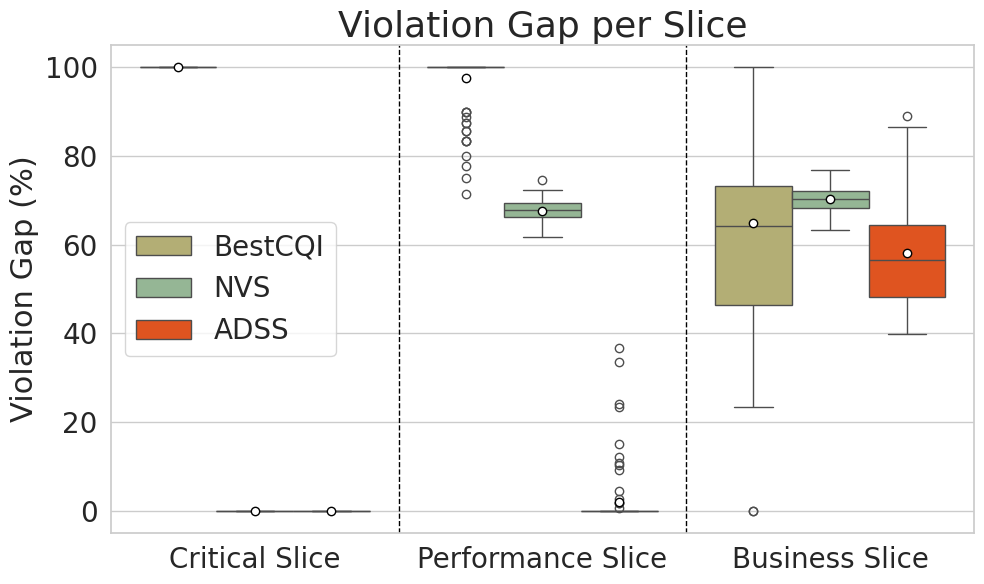

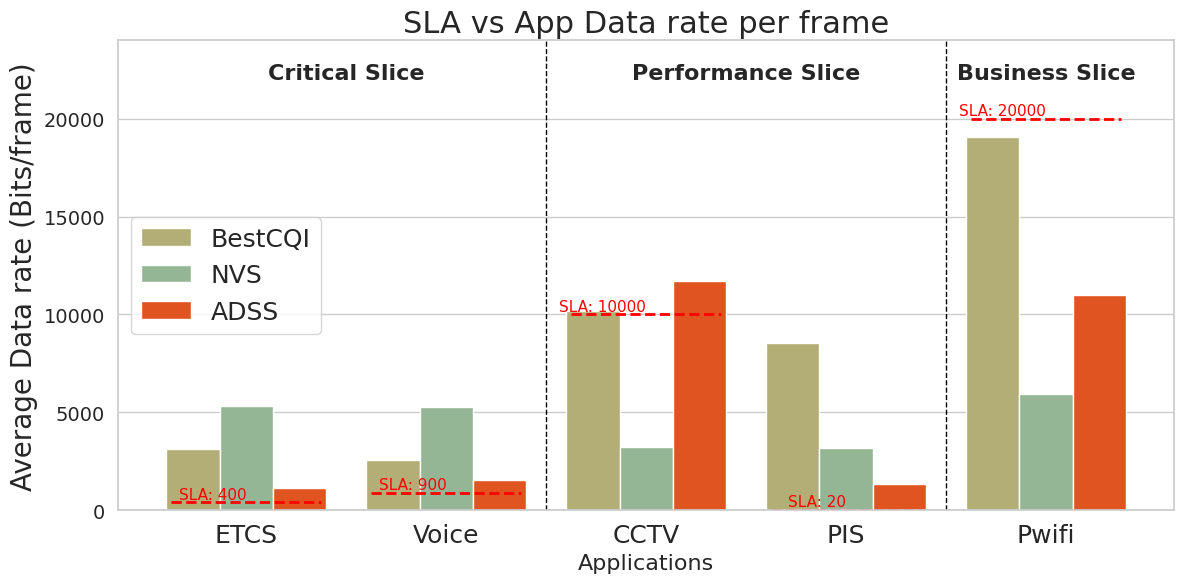

In [2]:
import random
import numpy as np
import pandas as pd
import time 
from gurobipy import Model, GRB, quicksum

from stable_baselines3.common.noise import NormalActionNoise
import matplotlib.pyplot as plt
import seaborn as sns
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
from typing import Optional

K = 25  
T = 10  
num_simulations = 100
N_SLICES = 4  # 0=critic, 1=perf, 2=busi, 3=none
    
# SLA dictionaries in bits
SLA_critic = {1: 400, 2:900}   
SLA_perf   = {3: 10000, 4: 20}  
SLA_busi   = {5: 20000}        


# Application categories identifier
Ac = [1, 2]  # Critical apps
Ap = [3, 4]  # Performance apps
Ab = [5]     # Business apps

U_c = 7 # number of critical UE
U_p = 7 # number of performance UE
U_b = 5  # number of business UE
#Policy network parameters
hidden_size=128
n_steps=25
agent_gamma = 0.97
lam=0.25
clip_range=0.96
lr=0.02
batch_size=64
n_epochs=8
alpha=0.8
lambda_weight=0.5
weights = {1:60, 2:8, 3:2}
total_timesteps=2000
partial_train_steps= 2000
train_episode= 10
# Application labels for plotting

app_labels = ['ETCS', 'Voice', 'CCTV', 'PIS', 'Pwifi']
sla_values = [
    SLA_critic.get(1, 0),
    SLA_critic.get(2, 0),
    SLA_perf.get(3, 0),
    SLA_perf.get(4, 0),
    SLA_busi.get(5, 0)
]
#Data Rate parameters

J = 1  # Number of component carriers
v_Llayers = 1  # Maximum number of MIMO layers

OH = 0.14  # Overhead (e.g., FR1 DL)
f = 1  # Scaling factor
mu = 0  # Numerology (0 for 15 kHz SCS)

# CQI to Modulation Order (Q_m)
CQI_TO_MCS = {
    1: 2, 2: 2, 3: 2, 4: 4, 5: 4,
    6: 4, 7: 4, 8: 6, 9: 6, 10: 6,
    11: 6, 12: 6, 13: 8, 14: 8, 15: 8
}

# CQI to Coding Rate (R_max)
CQI_TO_Rmax = {
    1: 0.07617188,  # QPSK
    2: 0.18847656,  # QPSK
    3: 0.43847656,  # QPSK
    4: 0.36914063,  # QPSK
    5: 0.47851563,  # QPSK
    6: 0.6015625,   # QPSK
    7: 0.45507813,  # 16-QAM
    8: 0.55371094,  # 16-QAM
    9: 0.65039063,  # 16-QAM
    10: 0.75390625, # 64-QAM
    11: 0.85253906, # 64-QAM
    12: 0.69433594, # 64-QAM
    13: 0.77832031, # 64-QAM
    14: 0.86425781, # 64-QAM
    15: 0.92578125, # 64-QAM
}

# OFDM symbol duration (T_s) based on numerology
T_s = 10**-3 / (14 * 2**mu)  # Symbol duration in seconds


def calculate_max_achievable_throughput():
    """
    Calculate the maximum achievable throughput in bits/ms for all PRBs with ideal CQI.
    """
    ideal_cqi = 15  # Ideal CQI value for maximum throughput
    R_max = CQI_TO_Rmax[ideal_cqi]
    Q_m = CQI_TO_MCS[ideal_cqi]

    # Max achievable throughput for all PRBs in Kb/ms
    max_achievable_throughput = (10**-6 *
        J
        * v_Llayers
        * Q_m
        * f
        * R_max
        * (K * 12 / T_s)
        * (1 - OH) * T
    )
    return max_achievable_throughput
max_achievable_throughput = calculate_max_achievable_throughput()
print(f"Max Achievable Throughput: {max_achievable_throughput:.3f} KB/frame")


# Generate gamma dictionary : representing the achievable datarate of each App for a given RB
def generate_gamma():
    
    min_cqi = 4
    max_cqi = 15
    gamma = {}

    # Business slice (s = 3)
    for i in range(U_b):

        for a in Ab:
            for k_ in range(K):
                cqi = random.randint(min_cqi, max_cqi)
                R_max = CQI_TO_Rmax.get(cqi, 0)
                Q_m = CQI_TO_MCS.get(cqi, 0)
                throughput = (10**-3 *
                    J
                    * v_Llayers
                    * Q_m
                    * f
                    * R_max
                    * (12 / T_s)
                    * (1 - OH)
                )  # Throughput per PRB in bits/ms
                gamma[(i, a, 3, k_)] = throughput
    # Performance slice (s = 2)
    for i in range(U_p):

        for a in Ap:
            for k_ in range(K):
                cqi = random.randint(min_cqi, max_cqi)
                R_max = CQI_TO_Rmax.get(cqi, 0)
                Q_m = CQI_TO_MCS.get(cqi, 0)
                throughput = ( 10**-3 *
                    J
                    * v_Llayers
                    * Q_m
                    * f
                    * R_max
                    * (12 / T_s)
                    * (1 - OH)
                )  # Throughput per PRB in bits/ms
                gamma[(i, a, 2, k_)] = throughput


    # Critical slice (s = 1)
    for i in range(U_c):

        for a in Ac:
            for k_ in range(K):
                cqi = random.randint(min_cqi, max_cqi)
                R_max = CQI_TO_Rmax.get(cqi, 0)
                Q_m = CQI_TO_MCS.get(cqi, 0)
                throughput = (10**-3 *
                    J
                    * v_Llayers
                    * Q_m
                    * f
                    * R_max
                    * (12 / T_s)
                    * (1 - OH)
                )  # Throughput per PRB in bits/ms
                gamma[(i, a, 1, k_)] = throughput


    return gamma



def build_appkey_list():
    appkey_list = []
    # slice=1 (Critical)
    for i in range(U_c):
        for a in Ac:
            appkey_list.append((i, a, 1))
    # slice=2 (Performance)
    for i in range(U_p):
        for a in Ap:
            appkey_list.append((i, a, 2))
    # slice=3 (Business)
    for i in range(U_b):
        for a in Ab:
            appkey_list.append((i, a, 3))
    return appkey_list

APPKEY_LIST = build_appkey_list()
N_APPKEYS = len(APPKEY_LIST)

def get_sla(app):
    if app in SLA_critic:
        return SLA_critic[app]
    if app in SLA_perf:
        return SLA_perf[app]
    if app in SLA_busi:
        return SLA_busi[app]
    return 0

def get_slice_for_app(app_id):
    if app_id in Ac:
        return 1
    elif app_id in Ap:
        return 2
    else:
        return 3

def get_num_users_for_slice(slice_id):
    if slice_id == 1:
        return U_c
    elif slice_id == 2:
        return U_p
    elif slice_id == 3:
        return U_b


def run_bestcqi_allocation(gamma):
    """
    Assign each PRB in each time slot to (i, a, s) that has the highest achievable throughput in gamma
  
    """
    prb_assignments = []

    for t in range(T):
        for k_ in range(K):
            best_key = None
            best_thr = 0.0
            for (i, a, s, k_val) in gamma:
                if k_val == k_:
                    thr_val = gamma[(i, a, s, k_val)]
                    if thr_val > best_thr:
                        best_thr = thr_val
                        best_key = (i, a, s)
            if best_key is not None:
                i, a, s = best_key
                prb_assignments.append((t, k_, i, a, s, best_thr))

    allocation_df = pd.DataFrame(prb_assignments, 
                                 columns=['Slot', 'PRB', 'User', 'App', 'Slice', 'Throughput'])
    #allocation_df.to_csv("bestcqi_allocation_df.csv", index=False)
    allocation_df['App_Key'] = allocation_df.apply(
        lambda row: (row['User'], row['App'], row['Slice']), axis=1
    )
    
    app_throughput_df = (
        allocation_df.groupby('App_Key')['Throughput'].sum().reset_index()
    )

    app_throughput_df[['User', 'App', 'Slice']] = pd.DataFrame(
        app_throughput_df['App_Key'].tolist(), index=app_throughput_df.index
    )
    app_throughput_df.drop(columns=['App_Key'], inplace=True)
    #app_throughput_df.to_csv("bestcqi_allocation_df.csv", index=False)
    
    # ===  Create a DataFrame of all ID combos from APPKEY_LIST ===
    all_combos_df = pd.DataFrame(APPKEY_LIST, columns=['User','App','Slice'])

    # ===  Merge with app_throughput_df, filling missing ID combos as Throughput=0 ===
    merged_df = all_combos_df.merge(
        app_throughput_df,
        on=['User','App','Slice'],
        how='left'
    )
    merged_df['Throughput'] = merged_df['Throughput'].fillna(0.0)

    # === compute the average throughput per App (including zero combos) ===
    app_episode_thr = (
        merged_df
        .groupby('App')['Throughput']
        .mean()
        .reset_index()
        .rename(columns={'Throughput': 'Average_Throughput'})
    )
    merged_df.to_csv("CQI_episode_app.csv", index=True)
    violation_counts_per_slice = {1: 0, 2: 0, 3: 0}
    violation_gap_per_slice = {1: 0, 2: 0, 3: 0}

    for (i_, a_, s_) in APPKEY_LIST:
        # Grab how much throughput was allocated to this (user, app, slice)
        row_match = app_throughput_df[
            (app_throughput_df['User'] == i_) &
            (app_throughput_df['App'] == a_) &
            (app_throughput_df['Slice'] == s_)
        ]
        sla_needed = get_sla(a_)
        if len(row_match) > 0:
            allocated_thr = row_match.iloc[0]['Throughput']
            ratio = allocated_thr / sla_needed
            if ratio < 1 :
                #gap_ratio = 1-ratio 
                violation_counts_per_slice[s_] += 1
                violation_gap_per_slice[s_] += (1.0 - ratio)
            

        else:
            allocated_thr = 0.0
            
            violation_counts_per_slice[s_] += 1
            violation_gap_per_slice[s_] += 1.0


  
    for s_ in [1, 2, 3]:
        if violation_counts_per_slice[s_] > 0:
            violation_gap_per_slice[s_] /= violation_counts_per_slice[s_]
        else:
            violation_gap_per_slice[s_] = 0.0

    total_violations = sum(violation_counts_per_slice.values())
    total_throughput = allocation_df['Throughput'].sum() 

    return (allocation_df, total_throughput, app_throughput_df,
            app_episode_thr, violation_counts_per_slice, total_violations, violation_gap_per_slice,)


def run_nvs_allocation(gamma):

    prb_assignments = []

    # Slot reservations based on slice priority 
    slot_reservation = {1: 5, 2: 3, 3: 2}
    current_slot = 0  # Start from zero

    for s, slice_slot_rsv in slot_reservation.items():
        
        # Gather all (i, a) pairs that belong to this slice 's'
        all_user_apps_for_s = sorted(
            list({(i, a_val) for (i, a_val, s_val, k_val) in gamma if s_val == s})
        )
        # If no (i, a) pairs are found, skip this slice
        if not all_user_apps_for_s:
            current_slot += slice_slot_rsv
            continue
       
        user_app_idx = 0
        num_pairs = len(all_user_apps_for_s)
        
        # Loop through the time slots for this slice
        for t in range(current_slot, current_slot + slice_slot_rsv):
            for k in range(K):
                attempts = 0
                assigned = False

                while not assigned and attempts < num_pairs:
                    # Pick the next (i, a) in a round-robin style
                    i_to_assign, a_to_assign = all_user_apps_for_s[user_app_idx]
                    user_app_idx = (user_app_idx + 1) % num_pairs
                    
                    if (i_to_assign, a_to_assign, s, k) in gamma:
                        thr_val = gamma[(i_to_assign, a_to_assign, s, k)]
                        prb_assignments.append((t, k, i_to_assign, a_to_assign, s, thr_val))
                        assigned = True
                    
                    attempts += 1

        current_slot += slice_slot_rsv

    # Build the allocation DataFrame
    allocation_df = pd.DataFrame(
        prb_assignments, 
        columns=['Slot', 'PRB', 'User', 'App', 'Slice', 'Throughput']
    )
    allocation_df['App_Key'] = allocation_df.apply(
        lambda row: (row['User'], row['App'], row['Slice']), axis=1
    )
    
    # Sum the throughput by App_Key => total throughput per (user, app, slice)
    app_throughput_df = (
        allocation_df
        .groupby('App_Key')['Throughput']
        .sum()
        .reset_index()
    )
    # Expand the tuples back into separate columns
    app_throughput_df[['User', 'App', 'Slice']] = pd.DataFrame(
        app_throughput_df['App_Key'].tolist(), 
        index=app_throughput_df.index
    )
    app_throughput_df.drop(columns=['App_Key'], inplace=True)

    
    #app_throughput_df.to_csv("NVS_allocation_df.csv", index=False)

    # === Create a DataFrame of all ID combos from APPKEY_LIST ===
    all_combos_df = pd.DataFrame(APPKEY_LIST, columns=['User','App','Slice'])

    # === Merge with app_throughput_df, filling missing combos as Throughput=0 ===
    merged_df = all_combos_df.merge(
        app_throughput_df,
        on=['User','App','Slice'],
        how='left'
    )
    merged_df['Throughput'] = merged_df['Throughput'].fillna(0.0)

    # === Compute the average throughput per App  ===
    app_episode_thr = (
        merged_df
        .groupby('App')['Throughput']
        .mean()
        .reset_index()
        .rename(columns={'Throughput': 'Average_Throughput'})
    )
    #merged_df.to_csv("NVS_episode_app.csv", index=True)

    violation_counts_per_slice = {1: 0, 2: 0, 3: 0}
    violation_gap_per_slice = {1: 0.0, 2: 0.0, 3: 0.0}


    for (i_, a_, s_) in APPKEY_LIST:
        # Grab how much throughput was allocated to this (user, app, slice)
        row_match = app_throughput_df[
            (app_throughput_df['User'] == i_) &
            (app_throughput_df['App'] == a_) &
            (app_throughput_df['Slice'] == s_)
        ]
        sla_needed = get_sla(a_)
        if len(row_match) > 0:
            allocated_thr = row_match.iloc[0]['Throughput']
            ratio = allocated_thr / sla_needed
            if ratio < 1 :
                #gap_ratio = 1-ratio 
                violation_counts_per_slice[s_] += 1
                violation_gap_per_slice[s_] += (1.0 - ratio)
            

        else:
            allocated_thr = 0.0
            
            violation_counts_per_slice[s_] += 1
            violation_gap_per_slice[s_] += 1.0


    
    for s_ in [1, 2, 3]:
        if violation_counts_per_slice[s_] > 0:
            violation_gap_per_slice[s_] /= violation_counts_per_slice[s_]
        else:
            violation_gap_per_slice[s_] = 0.0
            
    total_violations = sum(violation_counts_per_slice.values())
    total_throughput = allocation_df['Throughput'].sum() 

    return (
        allocation_df,              # PRB-level assignments
        total_throughput,           # sum of all throughput
        app_throughput_df,          # total throughput per (user, app, slice)
        app_episode_thr,            # average throughput (grouped by app)
        violation_counts_per_slice, # #violations per slice
        total_violations,           # overall violation count
        violation_gap_per_slice,    # final average gap ratio per slice
    )

# ------------------------
# ADSS Environment
# ------------------------

class MultiSliceAllocationEnv(gym.Env):
    def __init__(self, input_gamma=None):
        super(MultiSliceAllocationEnv, self).__init__()

        self.input_gamma = input_gamma

        # 4 discrete actions (0=critic, 1=perf, 2=busi, 3=none) per PRB
        self.action_space = gym.spaces.MultiDiscrete([4]*K)

        # Build an observation shape that includes:
        # time_step (1) + 3*gammma*K + 3*gap*K + 3*mask*K = 1 + 9*K
        obs_dim = 1 + 9*K
        self.observation_space = gym.spaces.Box(
            low=0.0, high=1e9, shape=(obs_dim,), dtype=np.float32
        )

        self.T = T  # number of time slots
        self.current_t = 0

        self.gamma_critic = [0.0]*K
        self.gamma_perf   = [0.0]*K
        self.gamma_busi   = [0.0]*K

        # hold a reference to gamma
        self.gamma = {}

        # Keep track of total allocations so far
        self.allocation_so_far = {}
        for ak in APPKEY_LIST:
            self.allocation_so_far[ak] = 0.0

        # Mask out apps that meet SLA
        self.mask_appkey = {ak: 1 for ak in APPKEY_LIST}

        # Keep track of allocations for metrics
        self.allocation_records = []

        # Store selection of "best" appkeys per slice per PRB
        self.best_critic_appkey = [None]*K
        self.best_perf_appkey   = [None]*K
        self.best_busi_appkey   = [None]*K

        self.reset()

    def reset(self):
        self.current_t = 0
        if self.input_gamma is not None:
            # Use external gamma if provided
            self.gamma = self.input_gamma
        else:
            # Otherwise generate a new gamma ,used for trainiing
            self.gamma = generate_gamma()

        # Reset allocations and mask
        for ak in APPKEY_LIST:
            self.allocation_so_far[ak] = 0.0
            self.mask_appkey[ak] = 1

        self.allocation_records.clear()

        return self._get_observation()

    def step(self, action):
        """
        action is shape (K,), each in [0..3]
        0=critic, 1=perf, 2=busi, 3=none
        """

        slice_map = [self.best_critic_appkey, self.best_perf_appkey, self.best_busi_appkey]

        for prb_idx in range(K):
            chosen_slice = action[prb_idx]
            if chosen_slice < 3:
                appk = slice_map[chosen_slice][prb_idx]
                if appk is not None:
                    thr = self.gamma.get((appk[0], appk[1], appk[2], prb_idx), 0.0)
                    self.allocation_so_far[appk] += thr
                    self.allocation_records.append(
                        (self.current_t, prb_idx, appk[0], appk[1], appk[2], thr)
                    )

        reward = 0.0
        for ak in APPKEY_LIST:
            sla_val = get_sla(ak[1])
            if sla_val > 0:
                allocated = self.allocation_so_far[ak]
                gap_ratio = allocated / sla_val
                if gap_ratio >= 1.0:
                    self.mask_appkey[ak] = 0
                    reward += (1.0 / gap_ratio) * weights[ak[2]]
                else:
                    reward -= (1 - gap_ratio) * weights[ak[2]]

        self.current_t += 1
        done = (self.current_t >= self.T)
        obs = self._get_observation()
        info = {}
        return obs, reward, done, info

    def _update_best_slices(self):

        # Temporary arrays to track best values/appkeys across all PRBs
        best_c_val = [0.0]*K
        best_p_val = [0.0]*K
        best_b_val = [0.0]*K
        best_c_app = [None]*K
        best_p_app = [None]*K
        best_b_app = [None]*K

        for (i, a, s, prb), thr in self.gamma.items():
            if self.mask_appkey.get((i, a, s), 1) == 1:
                if s == 1 and thr > best_c_val[prb]:
                    best_c_val[prb] = thr
                    best_c_app[prb] = (i, a, s)
                elif s == 2 and thr > best_p_val[prb]:
                    best_p_val[prb] = thr
                    best_p_app[prb] = (i, a, s)
                elif s == 3 and thr > best_b_val[prb]:
                    best_b_val[prb] = thr
                    best_b_app[prb] = (i, a, s)

        # update env-level references
        self.gamma_critic = best_c_val
        self.gamma_perf   = best_p_val
        self.gamma_busi   = best_b_val
        self.best_critic_appkey = best_c_app
        self.best_perf_appkey   = best_p_app
        self.best_busi_appkey   = best_b_app

    def _get_observation(self):
        """
        Build a 1D array with shape = 1 + 9*K:
          time_step (1),
          scaled gamma arrays (3*K),
          scaled gap arrays   (3*K),
          mask arrays         (3*K).
        """
        # 1) Identify best apps & fill self.gamma_critic, etc.
        self._update_best_slices()

        # 2) Scale gamma by 1070.055 (the best theoritical throughput when cqi is 15)
        gamma_c = [val / 1070.055 for val in self.gamma_critic]
        gamma_p = [val / 1070.055 for val in self.gamma_perf]
        gamma_b = [val / 1070.055 for val in self.gamma_busi]

        # Prepare gap & mask arrays
        gap_c   = [0.0]*K
        gap_p   = [0.0]*K
        gap_b   = [0.0]*K
        mask_c  = [0]*K
        mask_p  = [0]*K
        mask_b  = [0]*K

        # loop over K to fill gap + mask for each slice
        for k_ in range(K):
            # Critic
            c_app = self.best_critic_appkey[k_]
            if c_app is not None:
                sla_c = get_sla(c_app[1])
                alloc_c = self.allocation_so_far[c_app]
                if sla_c > 0:
                    raw_gap = max(0.0, sla_c - alloc_c)
                    gap_c[k_] = raw_gap / sla_c
                mask_c[k_] = 1 if alloc_c < sla_c else 0

            # Perf
            p_app = self.best_perf_appkey[k_]
            if p_app is not None:
                sla_p = get_sla(p_app[1])
                alloc_p = self.allocation_so_far[p_app]
                if sla_p > 0:
                    raw_gap = max(0.0, sla_p - alloc_p)
                    gap_p[k_] = raw_gap / sla_p
                mask_p[k_] = 1 if alloc_p < sla_p else 0

            # Busi
            b_app = self.best_busi_appkey[k_]
            if b_app is not None:
                sla_b = get_sla(b_app[1])
                alloc_b = self.allocation_so_far[b_app]
                if sla_b > 0:
                    raw_gap = max(0.0, sla_b - alloc_b)
                    gap_b[k_] = raw_gap / sla_b
                mask_b[k_] = 1 if alloc_b < sla_b else 0

        # Build final observation
        obs_list = []
        # (A) time step
        obs_list.append(float(self.current_t))
        # (B) scaled gamma arrays
        obs_list.extend(gamma_c)
        obs_list.extend(gamma_p)
        obs_list.extend(gamma_b)
        # (C) scaled gap arrays
        obs_list.extend(gap_c)
        obs_list.extend(gap_p)
        obs_list.extend(gap_b)
        # (D) mask arrays
        obs_list.extend(mask_c)
        obs_list.extend(mask_p)
        obs_list.extend(mask_b)

        return np.array(obs_list, dtype=np.float32)


class RolloutBuffer:

    def __init__(self, buffer_size, obs_dim, K):
        self.buffer_size = buffer_size
        self.obs_dim = obs_dim
        self.K = K
        self.observations = np.zeros((buffer_size, obs_dim), dtype=np.float32)
        self.actions = np.zeros((buffer_size, K), dtype=np.int32)
        self.rewards = np.zeros(buffer_size, dtype=np.float32)
        self.values = np.zeros(buffer_size, dtype=np.float32)
        self.dones = np.zeros(buffer_size, dtype=bool)
        self.logprobs = np.zeros(buffer_size, dtype=np.float32)
        self.advantages = np.zeros(buffer_size, dtype=np.float32)
        self.returns = np.zeros(buffer_size, dtype=np.float32)
        self.ptr = 0
        self.path_start_idx = 0

    def store(self, obs, action, reward, value, logprob, done):
        idx = self.ptr
        self.observations[idx] = obs
        self.actions[idx] = action
        self.rewards[idx] = reward
        self.values[idx] = value
        self.logprobs[idx] = logprob
        self.dones[idx] = done
        self.ptr += 1

    def finish_path(self, last_value, gamma=0.99, lam=0.95):
        path_end = self.ptr
        adv = 0.0
        for i in reversed(range(self.path_start_idx, path_end)):
            delta = self.rewards[i] + gamma * (
                0 if self.dones[i] else
                (last_value if i == (path_end-1) else self.values[i+1])
            ) - self.values[i]
            adv = delta + gamma * lam * (0 if self.dones[i] else adv)
            self.advantages[i] = adv
        for i in range(self.path_start_idx, path_end):
            self.returns[i] = self.values[i] + self.advantages[i]
        self.path_start_idx = self.ptr

    def get(self, batch_size, shuffle=True):
        idxs = np.arange(self.ptr)
        if shuffle:
            np.random.shuffle(idxs)
        start = 0
        while start < self.ptr:
            end = start + batch_size
            yield (
                self.observations[idxs[start:end]],
                self.actions[idxs[start:end]],
                self.advantages[idxs[start:end]],
                self.returns[idxs[start:end]],
                self.logprobs[idxs[start:end]]
            )
            start = end

    def reset(self):
        self.ptr = 0
        self.path_start_idx = 0


class PPOPolicyNet(nn.Module):

    def __init__(self, obs_dim, hidden_size, K, n_slices=4):
        super().__init__()
        self.obs_dim = obs_dim
        self.K = K
        self.n_slices = n_slices

        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )
        # policy head => K * 4
        self.policy_head = nn.Linear(hidden_size, K * n_slices)
        self.value_head = nn.Linear(hidden_size, 1)

    def forward(self, obs_t):
        h = self.net(obs_t)
        logits_1d = self.policy_head(h)
        # reshape => (batch_size, K, n_slices)
        logits_2d = logits_1d.view(-1, self.K, self.n_slices)
        value = self.value_head(h).squeeze(-1)
        return logits_2d, value


def build_distribution(policy_net, obs_t):
    """
    Build a multi-categorical distribution
    for shape (batch_size, K, 4).
    """
    device = next(policy_net.parameters()).device
    obs_t = obs_t.to(device)

    logits_2d, value = policy_net(obs_t)
    # logits_2d => shape (batch_size, K, 4)

    dist_list = []
    batch_size = obs_t.size(0)
    for b in range(batch_size):
        
        dists = []
        for k_ in range(policy_net.K):
            cat_logits = logits_2d[b, k_]
            dists.append(Categorical(logits=cat_logits))
        dist_list.append(dists)
    return dist_list, value


class PPOAgent:
    def __init__(self, env, K, obs_dim, hidden_size=128,
                 n_steps=2000, gamma=0.99, lam=0.95, clip_range=0.2, lr=3e-4,
                 batch_size=64, n_epochs=10):

        self.env = env
        self.K = K
        self.obs_dim = obs_dim
        self.gamma = gamma
        self.lam = lam
        self.clip_range = clip_range
        self.n_steps = n_steps
        self.batch_size = batch_size
        self.n_epochs = n_epochs

        self.policy_net = PPOPolicyNet(obs_dim, hidden_size, K, n_slices=4)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)

        self.buffer = RolloutBuffer(n_steps, obs_dim, K)

    def select_action(self, obs):
        obs_t = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        dist_list, value = build_distribution(self.policy_net, obs_t)
        # dist_list => length = batch_size=1 => [ list_of_K_distributions ]
        dists = dist_list[0]

        actions = []
        logps = []
        for d in dists:
            a = d.sample()
            actions.append(a)
            logps.append(d.log_prob(a))

        action_vec = torch.stack(actions, dim=0)  # shape (K,)
        logprob = torch.stack(logps).sum()

        return action_vec.numpy(), logprob.item(), value.item()

    def learn(self, total_timesteps=20000):
        obs = self.env.reset()
        for _ in range(total_timesteps):
            action, logprob, value = self.select_action(obs)
            next_obs, reward, done, info = self.env.step(action)
            self.buffer.store(obs, action, reward, value, logprob, done)
            obs = next_obs

            if done or (self.buffer.ptr >= self.n_steps):
                if done:
                    last_val = 0.0
                else:
                    obs_t = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
                    _, val_t = build_distribution(self.policy_net, obs_t)
                    last_val = val_t.item()

                self.buffer.finish_path(last_val, self.gamma, self.lam)
                self.update()
                self.buffer.reset()
                obs = self.env.reset()

    def update(self):
        for _ in range(self.n_epochs):
            for (obs_b, act_b, adv_b, ret_b, old_logp_b) in self.buffer.get(self.batch_size):
                obs_t = torch.tensor(obs_b, dtype=torch.float32)
                act_t = torch.tensor(act_b, dtype=torch.long)
                adv_t = torch.tensor(adv_b, dtype=torch.float32)
                ret_t = torch.tensor(ret_b, dtype=torch.float32)
                old_logp_t = torch.tensor(old_logp_b, dtype=torch.float32)

                dist_list, value_t = build_distribution(self.policy_net, obs_t)

                # compute log prob
                logp_list = []
                ent_list = []
                batch_size = obs_t.size(0)
                for b_idx in range(batch_size):
                    dists = dist_list[b_idx]  # a list of K Categorical
                    a_vec = act_t[b_idx]      # shape (K,)

                    lp_sum = 0.0
                    ent_sum = 0.0
                    for k_ in range(self.K):
                        lp_sum += dists[k_].log_prob(a_vec[k_])
                        ent_sum += dists[k_].entropy().mean()
                    logp_list.append(lp_sum)
                    ent_list.append(ent_sum / self.K)

                logp_new = torch.stack(logp_list)
                entropy = torch.stack(ent_list).mean()

                ratio = (logp_new - old_logp_t).exp()
                adv_norm = (adv_t - adv_t.mean()) / (adv_t.std() + 1e-8)

                surr1 = ratio * adv_norm
                surr2 = torch.clamp(ratio, 1.0 - self.clip_range, 1.0 + self.clip_range) * adv_norm
                policy_loss = -torch.min(surr1, surr2).mean()

                value_loss = nn.MSELoss()(value_t, ret_t)

                loss = policy_loss + 0.5 * value_loss - 0.01 * entropy
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

def compute_adss_allocation_metrics(env):
    columns = ['Slot','PRB','User','App','Slice','Throughput']
    alloc_df = pd.DataFrame(env.allocation_records, columns=columns)
    
    alloc_df.to_csv("allocation_df_adss.csv", index= True)
    total_thr = alloc_df['Throughput'].sum()
    avg_thr   = total_thr 
    total_prbs = K * T
    used_prbs  = len(alloc_df)  
    prb_usage_percent = (used_prbs / total_prbs) * 100 if total_prbs > 0 else 0

    # Summarize throughput per (User, App, Slice)
    app_thr_df = (
        alloc_df
        .groupby(['User','App','Slice'])['Throughput']
        .sum()
        .reset_index()
    )

    # -------------
    # 1) Violation & Gap Calculation 
    # -------------
    violation_counts_per_slice = {1: 0, 2: 0, 3: 0}
    violation_gap_per_slice    = {1: 0.0, 2: 0.0, 3: 0.0}
    for (i_, a_, s_) in APPKEY_LIST:
        # Grab how much throughput was allocated to this (user, app, slice)
        row_match = app_thr_df[
            (app_thr_df['User'] == i_) &
            (app_thr_df['App'] == a_) &
            (app_thr_df['Slice'] == s_)
        ]
        sla_needed = get_sla(a_)
        if len(row_match) > 0:
            allocated_thr = row_match.iloc[0]['Throughput']
            ratio = allocated_thr / sla_needed
            if ratio < 1 :
                #gap_ratio = 1-ratio 
                violation_counts_per_slice[s_] += 1
                violation_gap_per_slice[s_] += (1.0 - ratio)
            

        else:
            allocated_thr = 0.0
            
            violation_counts_per_slice[s_] += 1
            violation_gap_per_slice[s_] += 1.0


    # Final step: turn total gap into an average gap for each slice
    for s_ in [1, 2, 3]:
        if violation_counts_per_slice[s_] > 0:
            violation_gap_per_slice[s_] /= violation_counts_per_slice[s_]
        else:
            violation_gap_per_slice[s_] = 0.0

    total_violations = sum(violation_counts_per_slice.values())

    # gap ratio per App
    gap_ratios = {}
    for (i_, a_, s_) in APPKEY_LIST:
        mask = (
            (app_thr_df['User']  == i_) &
            (app_thr_df['App']   == a_) &
            (app_thr_df['Slice'] == s_)
        )
        allocated = app_thr_df.loc[mask, 'Throughput'].sum()
        sla_needed = get_sla(a_)
        ratio = ((sla_needed - allocated) / sla_needed) if sla_needed > 0 else 0.0
        ratio = max(0.0, ratio)
        gap_ratios.setdefault(a_, []).append(ratio)
    avg_gap_ratio_by_app = {app: np.mean(ratios) for app, ratios in gap_ratios.items()}

    # Average number of PRBs used per app
    prb_counts = alloc_df.groupby('App').size().to_dict()  # {app -> #rows}
    avg_prb_usage_by_app = {}
    for app_id, count in prb_counts.items():
        slice_id = get_slice_for_app(app_id)
        n_users = get_num_users_for_slice(slice_id)
        avg_prb_usage_by_app[app_id] = count / float(n_users) if n_users > 0 else 0

    # -------------
    # 3) Final Return
    # -------------
    return {
        'allocation_df': alloc_df,
        'Total_Throughput':       total_thr, 
        'Average_Throughput':     avg_thr,
        'PRB_Usage(%)':           prb_usage_percent,
        'Violation_Counts_Per_Slice': violation_counts_per_slice,
        'Violation_Gap_Per_Slice':    violation_gap_per_slice,
        'Total_Violations':       total_violations,
        'App_Throughput_DF':      app_thr_df,
        'Avg_Gap_Ratio_By_App':   avg_gap_ratio_by_app,
        'Avg_PRB_Usage_By_App':   avg_prb_usage_by_app,
    }, app_thr_df


def train_adss_agent(
    gamma, 
    num_episodes, 
    partial_train_steps
):

    env = MultiSliceAllocationEnv(
        input_gamma=gamma
    )
    obs_dim = env.observation_space.shape[0]

    # Initialize the PPO agent
    agent = PPOAgent(
        env=env,
        K=K,
        
        obs_dim=obs_dim,
        hidden_size=hidden_size,
        n_steps=n_steps, 
        gamma=agent_gamma,
        lam=lam,
        clip_range=clip_range,
        lr=lr,
        batch_size=batch_size,
        n_epochs=n_epochs
    )

    # Initialize lists to store metrics
    episodes = []
    throughputs = []
    prb_usages = []
    violations = []
    rewards = []
    avg_gap_ratios = []
    avg_prb_usages = []

    # Training loop
    for ep in range(num_episodes):
        # Train the agent for a specified number of timesteps
        agent.learn(total_timesteps=partial_train_steps)

        # Run a test episode to gather metrics
        test_env = MultiSliceAllocationEnv(
            input_gamma=gamma
        )
        obs = test_env.reset()
        done = False
        total_reward = 0.0

        while not done:
            action, _, _ = agent.select_action(obs)
            obs, rew, done, _ = test_env.step(action)
            total_reward += rew

        # Compute metrics using the provided function
        metrics, alloc_df = compute_adss_allocation_metrics(test_env)

        # Extract relevant metrics
        total_throughput = metrics['Total_Throughput']  # in KB
        prb_usage = metrics['PRB_Usage(%)']            # in percentage
        total_violations = metrics['Total_Violations']
        avg_gap_ratio = np.mean(list(metrics['Avg_Gap_Ratio_By_App'].values()))
        avg_prb_usage = np.mean(list(metrics['Avg_PRB_Usage_By_App'].values()))
        episode_reward = total_reward

        # Store metrics
        episodes.append(ep + 1)
        throughputs.append(total_throughput)
        prb_usages.append(prb_usage)
        violations.append(total_violations)
        rewards.append(episode_reward)
        avg_gap_ratios.append(avg_gap_ratio)
        avg_prb_usages.append(avg_prb_usage)

        # Print the metrics
        print(f"[Training Ep {ep + 1}] => "
              f"Thr={total_throughput:.2f}KB, "
              f"PRB_Usage={prb_usage:.1f}%, "
              f"Viol={total_violations}, "
              f"Reward={episode_reward:.2f}")

    # Compile metrics into a DataFrame
    training_results_df = pd.DataFrame({
        'Episode': episodes,
        'Total_Throughput_KB': throughputs,
        'PRB_Usage_%': prb_usages,
        'Total_Violations': violations,
        'Episode_Reward': rewards,
        'Avg_Gap_Ratio_By_App': avg_gap_ratios,
        'Avg_PRB_Usage_By_App': avg_prb_usages
    })

    return agent, env, training_results_df

def plot_training_metrics(training_results_df):
    
    sns.set(style="whitegrid")
    plt.rcParams.update({'figure.max_open_warning': 0}) 

    # Plot Episode Reward
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Episode', y='Episode_Reward', data=training_results_df, marker='o', color='purple')
    plt.xlabel('Episode')
    plt.ylabel('Episode Reward')
    plt.title('Training: Episode Rewards')
    plt.tight_layout()
    plt.show()

    # Plot Total Throughput
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Episode', y='Total_Throughput_KB', data=training_results_df, marker='o', color='green')
    plt.xlabel('Episode')
    plt.ylabel('Total Throughput (KB)')
    plt.title('Training: Total Throughput per Episode')
    plt.tight_layout()
    plt.show()



# ------------------------
# Main Simulation Run
# ------------------------
def run_simulation(num_simulations, alpha=alpha, lambda_weight=lambda_weight):
 
    simulation_results = []

    dummy_env = MultiSliceAllocationEnv(
        input_gamma=generate_gamma()
    )
    obs_dim = dummy_env.observation_space.shape[0]
    adss_agent = PPOAgent(
        env=dummy_env,
        K=K,
        obs_dim=obs_dim,
        hidden_size=hidden_size,
        n_steps=n_steps,
        gamma=agent_gamma,
        lam=lam,
        clip_range=clip_range,
        lr=lr,
        batch_size=batch_size,
        n_epochs=n_epochs
    )
    
    # Load the saved policy network weights into the agent's policy network.
    adss_agent.policy_net.load_state_dict(torch.load("ppo_policy_net.pth"))
    adss_agent.policy_net.eval()  # Set to evaluation mode
    print("Loaded trained policy network for inference!")


  
    # ------------------------------------------------------
    #  For each simulation, run the 4 methods
    # ------------------------------------------------------
    for sim in range(1, num_simulations + 1):
        print(f"\n=== Running simulation {sim}/{num_simulations} ===")

        # (A) Generate new gamma
        gamma = generate_gamma()
        gamma_df = pd.DataFrame(
            [(i, a, s, k, throughput) for (i, a, s, k), throughput in gamma.items()],
            columns=['User_Index', 'App_ID', 'Slice_ID', 'PRB', 'Throughput_bps_per_ms']
        )

        # Save the DataFrame to a CSV file
        #gamma_df.to_csv("gamma_data.csv", index=False)

        # (C) BestCQI
        start_time_bestcqi = time.time()
        (alloc_df_cqi,
         total_thr_cqi,
         app_thr_df_cqi,
         app_episode_thr_cqi,
         viol_cnt_cqi,
         tot_viol_cqi,
         viol_gap_cqi) = run_bestcqi_allocation(gamma)
        time_taken_bestcqi = time.time() - start_time_bestcqi
        
        avg_thr_per_app_cqi = {
            f"BestCQI_App_{int(app)}_Throughput": avg_thr
            for app, avg_thr in app_episode_thr_cqi[['App','Average_Throughput']].itertuples(index=False)
        }

        # (D) NVS
        start_time_nvs = time.time()
        (alloc_df_nvs,
         total_thr_nvs,
         app_thr_df_nvs,
         app_episode_thr_nvs,
         viol_cnt_nvs,
         tot_viol_nvs,
         viol_gap_nvs) = run_nvs_allocation(gamma)
        time_taken_nvs = time.time() - start_time_nvs

        avg_thr_per_app_nvs = {
            f"NVS_App_{int(app)}_Throughput": avg_thr
            for app, avg_thr in app_episode_thr_nvs[['App','Average_Throughput']].itertuples(index=False)
        }


        # (E) Create a new environment instance for the simulation.
        final_adss_env = MultiSliceAllocationEnv(
            input_gamma=gamma
        )
        obs = final_adss_env.reset()
        done = False
        total_reward = 0.0
        
        start_time_adss_allocation = time.time()
        while not done:
            # Use the loaded policy network via the agent to select an action.
            action, logp, val_est = adss_agent.select_action(obs)
            obs, rew, done, info = final_adss_env.step(action)
            total_reward += rew
        time_taken_adss_allocation = time.time() - start_time_adss_allocation

        # Gather ADSS metrics from final_adss_env.allocation_records
        metrics_adss, alloc_df_adss = compute_adss_allocation_metrics(final_adss_env)
        #alloc_df_adss.to_csv("allocation_adss_df.csv", index=False)
        adss_total_throughput = metrics_adss['Total_Throughput']   # bits/frame
        usage_adss = metrics_adss['PRB_Usage(%)']
        viol_cnt_adss = metrics_adss['Violation_Counts_Per_Slice']
        tot_viol_adss = metrics_adss['Total_Violations']
        viol_gap_adss = metrics_adss['Violation_Gap_Per_Slice']


        app_thr_df_adss = metrics_adss['App_Throughput_DF']
        # ===  Create a DataFrame of all ID combos from APPKEY_LIST ===
        all_combos_df = pd.DataFrame(APPKEY_LIST, columns=['User','App','Slice'])

        # === Merge with app_throughput_df, filling missing ID combos as Throughput=0 ===
        merged_df = all_combos_df.merge(
            app_thr_df_adss,
            on=['User','App','Slice'],
            how='left'
        )
        merged_df['Throughput'] = merged_df['Throughput'].fillna(0.0)

        # === compute the average throughput per App (including zero combos) ===
        app_episode_thr_adss = (
            merged_df
            .groupby('App')['Throughput']
            .mean()
            .reset_index()
            .rename(columns={'Throughput': 'Average_Throughput'})
        )
        merged_df.to_csv("ADSS_episode_app.csv", index=True)
        
        avg_thr_per_app_adss = {
            f"ADSS_App_{int(app)}_Throughput": avg_thr
            for app, avg_thr in app_episode_thr_adss[['App','Average_Throughput']].itertuples(index=False)
        }

        # (F) PRB usage for each method
        total_prbs = K * T
        
        usage_cqi = (len(alloc_df_cqi) / total_prbs * 100) if alloc_df_cqi is not None else 0
        usage_nvs = (len(alloc_df_nvs) / total_prbs * 100) if alloc_df_nvs is not None else 0

        # #apps per slice
        num_apps_slice = {
            s: len({(i, a) for (i, a, s_val, k_) in gamma.keys() if s_val == s})
            for s in [1,2,3]
        }

        # BestCQI
        violation_rate_cqi = {
            f"BestCQI_Violation_Rate_S{s}": (
                viol_cnt_cqi.get(s, 0) / num_apps_slice[s] * 100
            ) if num_apps_slice[s]>0 else 0
            for s in [1,2,3]
        }
        # NVS
        violation_rate_nvs = {
            f"NVS_Violation_Rate_S{s}": (
                viol_cnt_nvs.get(s, 0) / num_apps_slice[s] * 100
            ) if num_apps_slice[s]>0 else 0
            for s in [1,2,3]
        }
        # ADSS
        violation_rate_adss = {
            f"ADSS_Violation_Rate_S{s}": (
                viol_cnt_adss.get(s, 0)/ num_apps_slice[s]*100
            ) if num_apps_slice[s]>0 else 0
            for s in [1,2,3]
        }

        violation_rates = {
            
            **violation_rate_cqi,
            **violation_rate_nvs,
            **violation_rate_adss
        }


        violation_gap_rate_cqi = {
            f"BestCQI_Violation_gap_S{s}": viol_gap_cqi.get(s,0) for s in [1,2,3]
        }
        violation_gap_rate_nvs = {
            f"NVS_Violation_gap_S{s}": viol_gap_nvs.get(s,0) for s in [1,2,3]
        }
        violation_gap_rate_adss = {
            f"ADSS_Violation_gap_S{s}": viol_gap_adss.get(s,0) for s in [1,2,3]
        }
        violation_gap_rates = {
            
            **violation_gap_rate_cqi,
            **violation_gap_rate_nvs,
            **violation_gap_rate_adss
        }

        simulation_results.append({
            'Simulation': sim,
            
            # BestCQI
            'BestCQI_Total_Throughput': total_thr_cqi*0.001,
            'BestCQI_PRB_Usage (%)': usage_cqi,
            'BestCQI_Time_Taken': time_taken_bestcqi,
            'BestCQI_Violations_S1': viol_cnt_cqi.get(1,0),
            'BestCQI_Violations_S2': viol_cnt_cqi.get(2,0),
            'BestCQI_Violations_S3': viol_cnt_cqi.get(3,0),
            'BestCQI_Total_Violations': tot_viol_cqi,

            # NVS
            'NVS_Total_Throughput': total_thr_nvs*0.001,
            'NVS_PRB_Usage (%)': usage_nvs,
            'NVS_Time_Taken': time_taken_nvs,
            'NVS_Violations_S1': viol_cnt_nvs.get(1,0),
            'NVS_Violations_S2': viol_cnt_nvs.get(2,0),
            'NVS_Violations_S3': viol_cnt_nvs.get(3,0),
            'NVS_Total_Violations': tot_viol_nvs,

            # ADSS
            'ADSS_Total_Throughput': adss_total_throughput*0.001,
            'ADSS_PRB_Usage (%)': usage_adss,
            'ADSS_Time_Taken': time_taken_adss_allocation,
            'ADSS_Violations_S1': viol_cnt_adss.get(1,0),
            'ADSS_Violations_S2': viol_cnt_adss.get(2,0),
            'ADSS_Violations_S3': viol_cnt_adss.get(3,0),
            'ADSS_Total_Violations': tot_viol_adss,

            # Max achievable
            'Max_Achievable_Throughput': max_achievable_throughput,

            # Collect violation rates
            **violation_rates,
            # Collect violation gap dictionary
            **violation_gap_rates,
            
            # Per-app throughput
            
            **avg_thr_per_app_cqi,
            **avg_thr_per_app_nvs,
            **avg_thr_per_app_adss
        })
        print(f"[Sim {sim}] => ")
        print(f"Time taken by ADSS: {time_taken_adss_allocation:.4f} seconds")
        print("-"*60)

    results_df = pd.DataFrame(simulation_results)
    #print("\n=== Simulation Results ===")
    #print(results_df.head())

  
    return results_df

# ------------------------
# Plotting
# ------------------------

def plot_all_results(results_df):
    sns.set(style="whitegrid")
    
    # 1) Total Throughput
    if 'Max_Achievable_Throughput' not in results_df.columns:
        print("Error: 'Max_Achievable_Throughput' column is missing.")
        return
    max_thr = results_df['Max_Achievable_Throughput'].iloc[0]
    
    plt.figure(figsize=(10, 6))
    
    plt.plot(results_df['Simulation'], results_df['BestCQI_Total_Throughput'],
             marker='s', label='BestCQI', color='#BDB76B')
    plt.plot(results_df['Simulation'], results_df['NVS_Total_Throughput'],
             marker='^', label='NVS', color='darkseagreen')
    plt.plot(results_df['Simulation'], results_df['ADSS_Total_Throughput'],
             marker='v', label='ADSS', color='orangered')
    plt.axhline(y=max_thr, color='r', linestyle='--')
    plt.text(results_df['Simulation'].min(), max_thr + max_thr*0.01, 
             f'Max Achievable: {max_thr:.2f} KB', 
             color='r', fontsize=10, ha='left')
    plt.xlabel('Allocation Episodes', fontsize=22)
    plt.ylabel('Data rate (Kbit/frame)', fontsize=22)
    plt.title('Data rate per Episodes', fontsize=26)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=18)
    plt.legend(fontsize=20)
    plt.tight_layout()
    plt.show()

    # Define the mapping from slice number to slice name
    slice_mapping = {1: 'Critical Slice', 2: 'Performance Slice', 3: 'Business Slice'}

    # 3) Violation Counts per Slice
    slice_nums = [1, 2, 3]
    violation_data = []
    for _, row in results_df.iterrows():
        sim = row['Simulation']
        for method, prefix in [
                            ('BestCQI', 'BestCQI'),
                            ('NVS', 'NVS'),
                            ('ADSS', 'ADSS')]:
            for s in slice_nums:
                violation_data.append({
                    'Simulation': sim,
                    'Method': method,
                    'Slice': slice_mapping[s],  # use the mapped slice name
                    'Violation_Count': row.get(f'{prefix}_Violations_S{s}', 0)
                })
    violation_df = pd.DataFrame(violation_data)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=violation_df, x='Slice', y='Violation_Count', hue='Method', errorbar=None,
                palette={'BestCQI': '#BDB76B', 'NVS': 'darkseagreen', 'ADSS': 'orangered'})
    plt.title('Average Violation occurrence per Slice')
    
    plt.ylabel('Violation occurrence per allocation episode')
    plt.legend(fontsize=16)
    plt.tight_layout()
    plt.show()

    # 4) Violation Rates per Slice
    violation_rate_data = []
    for _, row in results_df.iterrows():
        sim = row['Simulation']
        for s in slice_nums:
            violation_rate_data.append({
                'Simulation': sim,
                'Method': 'BestCQI',
                'Slice': slice_mapping[s],
                'Violation_Rate (%)': row.get(f'BestCQI_Violation_Rate_S{s}', 0)
            })
            violation_rate_data.append({
                'Simulation': sim,
                'Method': 'NVS',
                'Slice': slice_mapping[s],
                'Violation_Rate (%)': row.get(f'NVS_Violation_Rate_S{s}', 0)
            })
            violation_rate_data.append({
                'Simulation': sim,
                'Method': 'ADSS',
                'Slice': slice_mapping[s],
                'Violation_Rate (%)': row.get(f'ADSS_Violation_Rate_S{s}', 0)
            })
    violation_rate_df = pd.DataFrame(violation_rate_data)

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=violation_rate_df, x='Slice', y='Violation_Rate (%)', hue='Method', errorbar=None,
                palette={'BestCQI': '#BDB76B', 'NVS': 'darkseagreen', 'ADSS': 'orangered'})
    ax.set_xlabel("")
    plt.title('Violation Rate per Slice', fontsize=26)
    
    plt.ylabel('Violation Rate (%)', fontsize=22)
    plt.legend(fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout()
    plt.show()

    # Violation Gap per Slice
    violation_gap_data = []
    for _, row in results_df.iterrows():
        sim = row['Simulation']
        for method, prefix in [
                            ('BestCQI', 'BestCQI'),
                            ('NVS', 'NVS'),
                            ('ADSS', 'ADSS')]:
            for s in slice_nums:
                violation_gap_data.append({
                    'Simulation': sim,
                    'Method': method,
                    'Slice': slice_mapping[s],
                    'Violation_gap': row.get(f'{prefix}_Violation_gap_S{s}', 0)*100
                })
    violation_gap_df = pd.DataFrame(violation_gap_data)

    plt.figure(figsize=(10, 6))
    ax = sns.boxplot(
        x="Slice", 
        y="Violation_gap", 
        hue="Method", 
        data=violation_gap_df, 
        showmeans=True,
        palette={'BestCQI': '#BDB76B', 'NVS': 'darkseagreen', 'ADSS': 'orangered'},
        meanprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "black"}
    )
    ax.set_xlabel("")
    # Add vertical lines to separate slices
    for i in range(1, len(violation_gap_df["Slice"].unique())):
        plt.axvline(x=i - 0.5, color="black", linestyle="--", linewidth=1)

    plt.title("Violation Gap per Slice", fontsize=26)
    
    plt.ylabel("Violation Gap (%)", fontsize=22)
    plt.legend(fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout()
    plt.show()

    # 5) Average Throughput per Application
    bestcqi_app_cols = [c for c in results_df.columns if c.startswith("BestCQI_App_")]
    nvs_app_cols = [c for c in results_df.columns if c.startswith("NVS_App_")]
    adss_app_cols = [c for c in results_df.columns if c.startswith("ADSS_App_")]

    if len(bestcqi_app_cols) != len(app_labels):
        print("Warning: # of BestCQI app columns != # of apps. Plot might be misaligned.")
    if len(nvs_app_cols) != len(app_labels):
        print("Warning: # of NVS app columns != # of apps. Plot might be misaligned.")
    if len(adss_app_cols) != len(app_labels):
        print("Warning: # of ADSS app columns != # of apps. Plot might be misaligned.")

    # Calculate average throughput per app across all simulations
    avg_thr_per_app_cqi = results_df[bestcqi_app_cols].mean().to_dict() if len(bestcqi_app_cols) > 0 else {}
    avg_thr_per_app_nvs = results_df[nvs_app_cols].mean().to_dict() if len(nvs_app_cols) > 0 else {}
    avg_thr_per_app_adss  = results_df[adss_app_cols].mean().to_dict()  if len(adss_app_cols)  > 0 else {}

    achieved_throughput_data = {
        'Application': app_labels,
        'SLA': sla_values,
        'BestCQI': [
            avg_thr_per_app_cqi.get(f"BestCQI_App_{i+1}_Throughput", 0)
            for i in range(len(app_labels))
        ],
        'NVS': [
            avg_thr_per_app_nvs.get(f"NVS_App_{i+1}_Throughput", 0)
            for i in range(len(app_labels))
        ],
        'ADSS': [
            avg_thr_per_app_adss.get(f"ADSS_App_{i+1}_Throughput", 0)
            for i in range(len(app_labels))
        ]
    }
    achieved_throughput_df = pd.DataFrame(achieved_throughput_data)
    achieved_throughput_df_melted = achieved_throughput_df.melt(
        id_vars=['Application', 'SLA'], var_name='Method', value_name='Throughput'
    )

    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=achieved_throughput_df_melted,
        x='Application', y='Throughput', hue='Method',
        palette={'BestCQI': '#BDB76B', 'NVS': 'darkseagreen', 'ADSS': 'orangered'}
    )

    # Plot the SLA lines for each application
    bar_width = 0.25
    app_positions = np.arange(len(app_labels))
    for i, (app, sla) in enumerate(zip(app_labels, sla_values)):
        x_start = app_positions[i] - (1.5 * bar_width)
        x_end   = app_positions[i] + (1.5 * bar_width)
        plt.plot([x_start, x_end], [sla, sla], color='red', linestyle='--', linewidth=2)
        # Slightly offset the text above the SLA line
        plt.text(
            i, sla + achieved_throughput_df_melted['Throughput'].max() * 0.01,
            f"SLA: {sla}", color='red', ha='right', fontsize=11
        )

    plt.axvline(x=1.5, color='black', linestyle='--', linewidth=1)  # between app1/app2 and app3/app4
    plt.axvline(x=3.5, color='black', linestyle='--', linewidth=1)  # between app3/app4 and app5

    # Increasing the y-limit so there's room for slice labels
    max_thr = achieved_throughput_df_melted['Throughput'].max()
    max_sla = max(sla_values)
    ymax = max(max_thr, max_sla)
    plt.ylim(top=ymax * 1.2) 

    # Place text above each group
    plt.text(0.5, ymax * 1.1, 'Critical Slice', ha='center', fontsize=16, fontweight='bold')
    plt.text(2.5, ymax * 1.1, 'Performance Slice', ha='center', fontsize=16, fontweight='bold')
    plt.text(4,   ymax * 1.1, 'Business Slice', ha='center', fontsize=16, fontweight='bold')

    # -----------------------------------------------------

    plt.ylabel('Average Data rate (Bits/frame)', fontsize=20)
    plt.xlabel('Applications', fontsize=16)
    plt.title('SLA vs App Data rate per frame', fontsize=22)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=18)
    plt.tight_layout()
    plt.show()


# ------------------------
# Final Results Overview
# ------------------------

def print_final_results(results_df):
    """
    Print a final summary table of the key stats from each simulation.
    """
    summary_cols = [
        'Simulation',
        'Optimal_ILP_Time_Taken',
        'BestCQI_Time_Taken',
        'NVS_Time_Taken',
        'ADSS_Time_Taken',
    ]
    # Collect columns for throughput per app
    
    app_cols_cqi = [c for c in results_df.columns if c.startswith("BestCQI_App_")]
    app_cols_nvs = [c for c in results_df.columns if c.startswith("NVS_App_")]
    app_cols_adss  = [c for c in results_df.columns if c.startswith("ADSS_App_")]
    
    all_cols = summary_cols + app_cols_cqi + app_cols_nvs + app_cols_adss
    available_cols = [c for c in all_cols if c in results_df.columns]

    print("\n=== Final Results Overview ===")
    print(results_df[available_cols].to_string(index=False))

results_df = run_simulation(num_simulations=num_simulations, alpha=0.8, lambda_weight=0.7)
#print_final_results(results_df)
plot_all_results(results_df)